In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize']=(6,6)
#plt.rcParams['font.weight']='bold'
#plt.rcParams['axes.labelweight']='bold'
#plt.rcParams['lines.linewidth']=1.5
#plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh, gs_Domain
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

from omfit_classes.omfit_eqdsk import boundaryShape

In [2]:
def resize_polygon(points, dx):
    new_points = np.empty(np.shape(points))
    for i in range(np.shape(points)[0]):
        if i==0:
            last = points[-1,:]
            next = points[i+1,:]
        elif i == np.shape(points)[0]-1:
            last = points[i-1,:]
            next = points[0,:]
        else:
            next = points[i+1,:]
            last = points[i-1,:]
        par = points[i,:]-last
        par/= np.linalg.norm(par)
        perp = np.array([par[1], -par[0]])
        temp = points[i,:] + perp*dx
        par_2 = next-points[i,:]
        par_2/= np.linalg.norm(par_2)
        perp_2 = [par_2[1], -par_2[0]]
        new_points[i, :] = temp + dx/np.dot(perp_2,par)*par  + par*dx/np.dot(par_2,perp)*np.dot(par_2,par)
    return new_points

def corners(r,z,dr,dz):
    rs = np.array([r+dr/2, r+dr/2, r-dr/2, r-dr/2, r+dr/2])
    zs = np.array([z+dz/2, z-dz/2, z-dz/2, z+dz/2, z+dz/2])
    return np.column_stack((rs,zs))

def place_points(npoints, arc):
    arclength = np.zeros(np.size(arc[:,0]))
    for i,point in enumerate(arc):
        if i==0:
            arclength[i] = 0
        else:

            arclength[i] = arclength[i-1] + ((arc[i,0]-arc[i-1,0])**2+(arc[i,1]-arc[i-1,1])**2)**0.5

    spacing = arclength[-1]/npoints
    curr = 1
    inds = [0]
    locs = [arc[0,:]]
    for i, point in enumerate(arc):
        if(arclength[i]>curr*spacing and curr<npoints):
            inds.append(i)
            locs.append(arc[i])
            curr+=1
    return np.array(inds), np.array(locs)

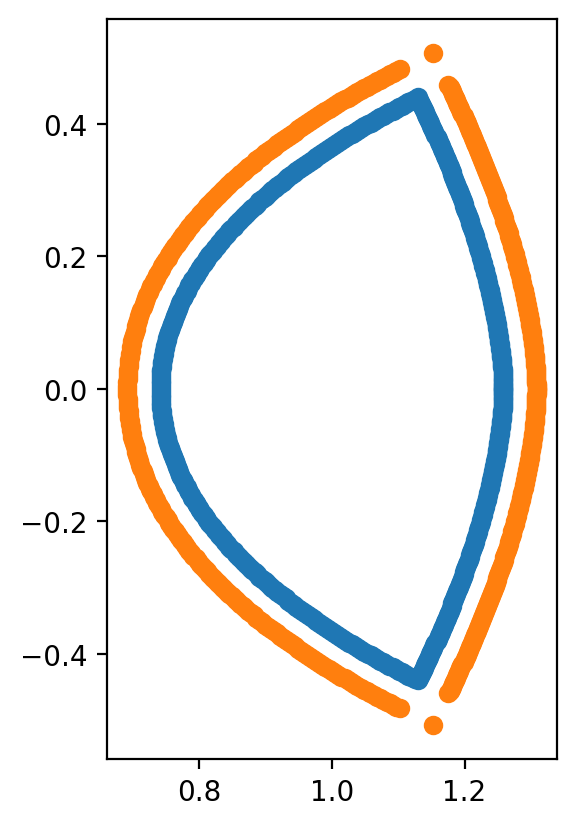

In [3]:
e = 1.7
d = -0.5
r, z, zeff = boundaryShape(kapu = e, kapl = e, delu = d, dell = d, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/1, zoffset = 0, upnull = True, lonull = True, npts = 128)
boundary = np.column_stack((r,z))
boundary = np.nan_to_num(boundary)

plt.scatter(boundary[:,0], boundary[:,1])
plt.gca().set_aspect(aspect = 1)

plate_arc = resize_polygon(boundary, 0.05)
plt.scatter(plate_arc[:,0], plate_arc[:,1])

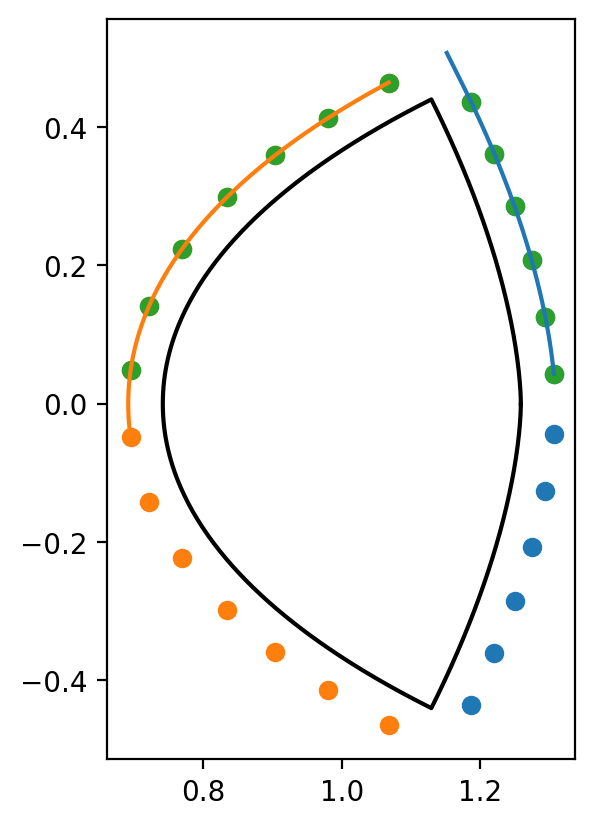

In [4]:
plt.gca().set_aspect(aspect = 1)
plt.plot(boundary[:,0], boundary[:,1], c= 'k')
ps_ur = plate_arc[15:129,:]
ps_ul = plate_arc[136:266,:]

plt.plot(ps_ur[:,0], ps_ur[:,1])
plt.plot(ps_ul[:,0], ps_ul[:,1])

inds_ur, locs_ur = place_points(6,ps_ur)
inds_ul, locs_ul = place_points(7,ps_ul)


plt.scatter(locs_ur[:,0], locs_ur[:,1])
plt.scatter(locs_ur[:,0], -locs_ur[:,1],  c = 'tab:blue')
plt.scatter(locs_ul[:,0], locs_ul[:,1])
plt.scatter(locs_ul[:,0], -locs_ul[:,1], c = 'tab:orange')

inds = np.concatenate((inds_ur + 15, inds_ul+136))
plt.scatter(plate_arc[inds,0], plate_arc[inds,1])


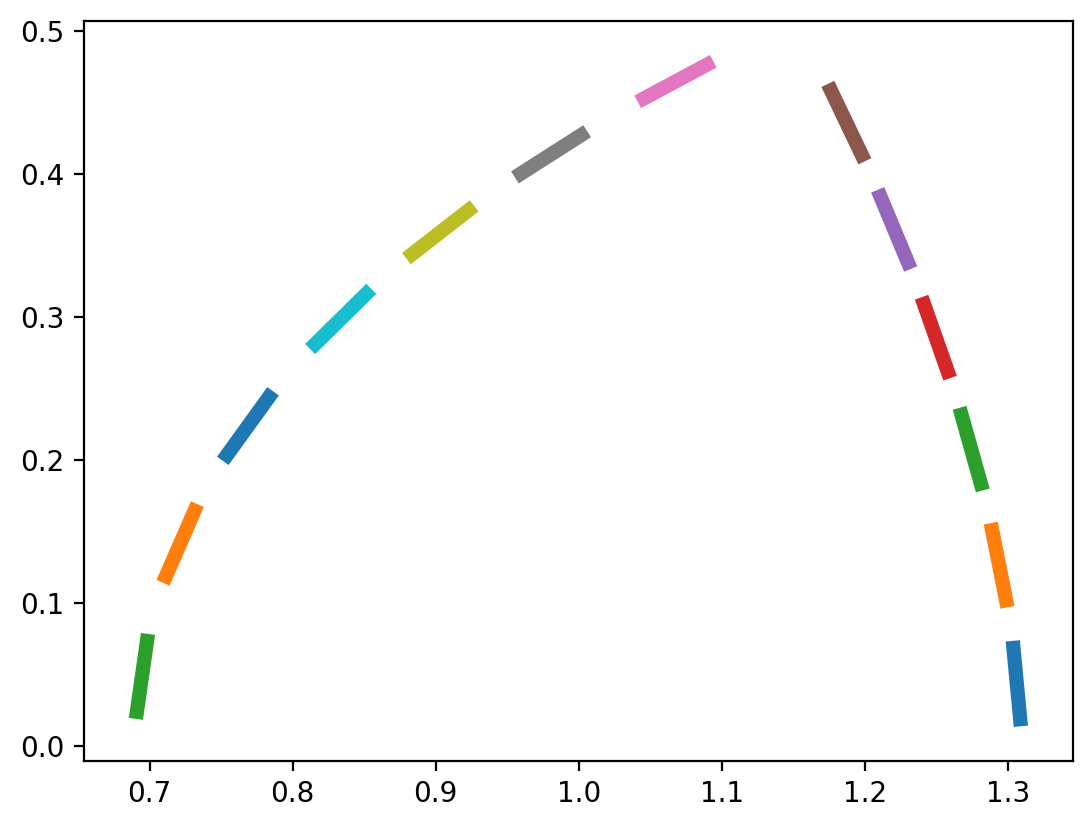

In [5]:
derivs = []
for i, point in enumerate(plate_arc):
    if i==0:
        last = plate_arc[-1,:]
        next = plate_arc[i+1,:]
    elif i == np.size(plate_arc[:,0])-1:
        last = plate_arc[i-1,:]
        next = plate_arc[0,:]
    else: 
        next = plate_arc[i+1,:]
        last = plate_arc[i-1,:]
    
    derivs.append((next-last)/np.linalg.norm(next-last))

derivs = np.array(derivs)
orth = np.transpose([derivs[:,1], -derivs[:,0]])
length = .06
width = .01
ps_points = []
for i in inds:
    center = plate_arc[i,:]
    p1 = center + length/2*derivs[i,:] + width/2*orth[i,:]
    p2 = center + length/2*derivs[i,:] - width/2*orth[i,:]
    p3 = center - length/2*derivs[i,:] - width/2*orth[i,:]
    p4 = center - length/2*derivs[i,:] + width/2*orth[i,:]

    ps_points.append([p1, p2, p3, p4])

ps_points = np.array(ps_points)
for i in range(13):
    plt.fill(ps_points[i,:,0], ps_points[i,:,1])

plt.gca().set_aspect(aspect = 1)

In [6]:
##things needed for mesh

plasma_dx = 0.02
coil_dx = 0.04
vv_dx = 0.01
vac_dx = 0.075

import json
with open('nsf_geom_new.json','r') as fid:
    nsf_geom = json.load(fid)

In [7]:
def resize_polygon(points, dx):
    new_points = np.empty(np.shape(points))
    for i in range(np.shape(points)[0]):
        if i==0:
            last = points[-1,:]
            next = points[i+1,:]
        elif i == np.shape(points)[0]-1:
            last = points[i-1,:]
            next = points[0,:]
        else:
            next = points[i+1,:]
            last = points[i-1,:]
        par = points[i,:]-last
        par/= np.linalg.norm(par)
        perp = np.array([par[1], -par[0]])
        temp = points[i,:] + perp*dx
        par_2 = next-points[i,:]
        par_2/= np.linalg.norm(par_2)
        perp_2 = [par_2[1], -par_2[0]]
        new_points[i, :] = temp + dx/np.dot(perp_2,par)*par  + par*dx/np.dot(par_2,perp)*np.dot(par_2,par)
    return new_points

def corners(r,z,dr,dz):
    rs = np.array([r+dr/2, r+dr/2, r-dr/2, r-dr/2, r+dr/2])
    zs = np.array([z+dz/2, z-dz/2, z-dz/2, z+dz/2, z+dz/2])
    return np.column_stack((rs,zs))

r,z,zeff= boundaryShape(kapu = 1.55, kapl = 1.55, delu = -0.4, dell = -0.4, zetail = -.03, zetaiu = -.03, zetaou = -.03, zetaol = -.03, a = 0.413, eps = 0.413/1.02, zoffset = 0, upnull = False, lonull = False, npts = 8)
lim1 = np.column_stack((r,z))

lim2 = resize_polygon(lim1, -0.05)
vv2 = resize_polygon(lim2, 0.01)

In [9]:
print(repr(lim2))

array([[ 1.38295616,  0.        ],
       [ 1.37819627,  0.1136394 ],
       [ 1.36411987,  0.22839392],
       [ 1.34147837,  0.33535708],
       [ 1.31160087,  0.428733  ],
       [ 1.27659351,  0.50348616],
       [ 1.23989537,  0.55532746],
       [ 1.20721657,  0.58207902],
       [ 1.18129551,  0.58932473],
       [ 1.0902428 ,  0.57841675],
       [ 0.99292215,  0.544273  ],
       [ 0.90082552,  0.48851609],
       [ 0.81867131,  0.41333246],
       [ 0.75043826,  0.32194035],
       [ 0.69936479,  0.2185339 ],
       [ 0.66782749,  0.10834806],
       [ 0.65723823,  0.        ],
       [ 0.66782749, -0.10834806],
       [ 0.69936479, -0.2185339 ],
       [ 0.75043826, -0.32194035],
       [ 0.81867131, -0.41333246],
       [ 0.90082552, -0.48851609],
       [ 0.99292215, -0.544273  ],
       [ 1.0902428 , -0.57841675],
       [ 1.18129551, -0.58932473],
       [ 1.20721657, -0.58207902],
       [ 1.23989537, -0.55532746],
       [ 1.27659351, -0.50348616],
       [ 1.31160087,

In [8]:
coils = {
    'CS0': {'rc': 0.58, 'zc': -.615, 'w': 0.075, 'h': 0.43},
    'CS1': {'rc': 0.58, 'zc': 0, 'w': 0.075, 'h': 0.8},
    'CS2': {'rc': 0.58, 'zc': .615, 'w': 0.075, 'h': 0.43},

    'EF0U': {'rc': .738, 'zc': 0.6, 'w': 0.125, 'h': 0.125},
    'EF1U': {'rc': 1.2, 'zc': 0.75, 'w': 0.175, 'h': 0.175},
    'EF2U': {'rc': 1.4, 'zc': 0.600, 'w': 0.15, 'h': 0.15},
    'EF3U': {'rc': 1.95, 'zc': 0.3, 'w': .175, 'h': .175},

    'EF0L': {'rc': .738, 'zc': -0.6, 'w': 0.125, 'h': 0.15},
    'EF1L': {'rc': 1.2, 'zc': -0.75, 'w': 0.175, 'h': 0.175},
    'EF2L': {'rc': 1.4, 'zc': -0.600, 'w': 0.15, 'h': 0.15},
    'EF3L': {'rc': 1.95, 'zc': -0.3, 'w': .175, 'h': .175},
  
}

Assembling regions:
  # of unique points    = 949
  # of unique segments  = 56
Generating mesh:
  # of points  = 5052
  # of cells   = 9986
  # of regions = 16
#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          aba6d8f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.914E+00
    # of points  =    5052
    # of edges   =   15037
    # of cells   =    9986
    # of boundary points =   

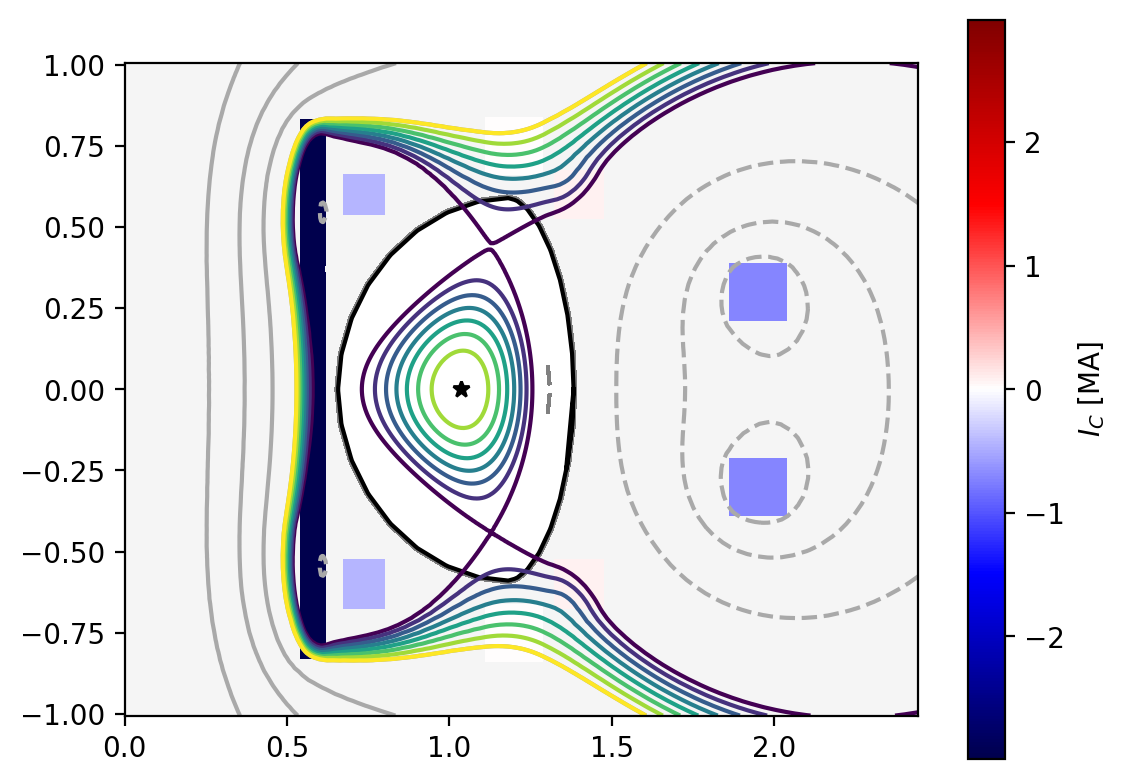

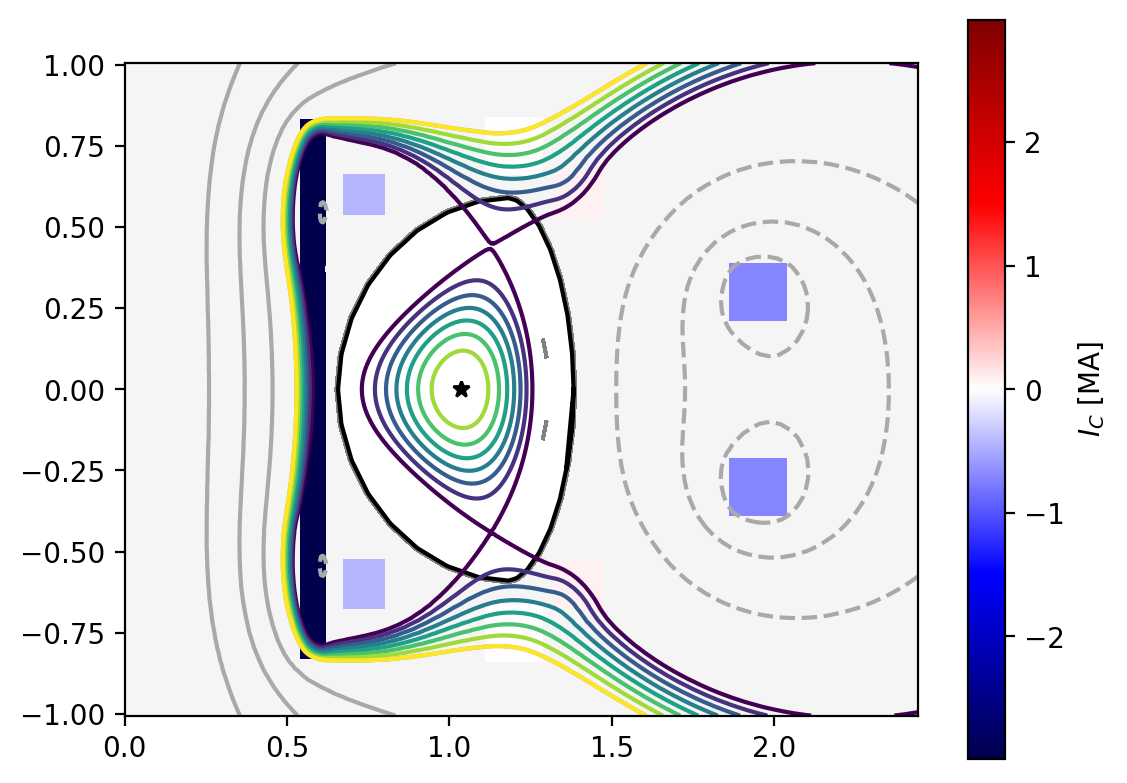

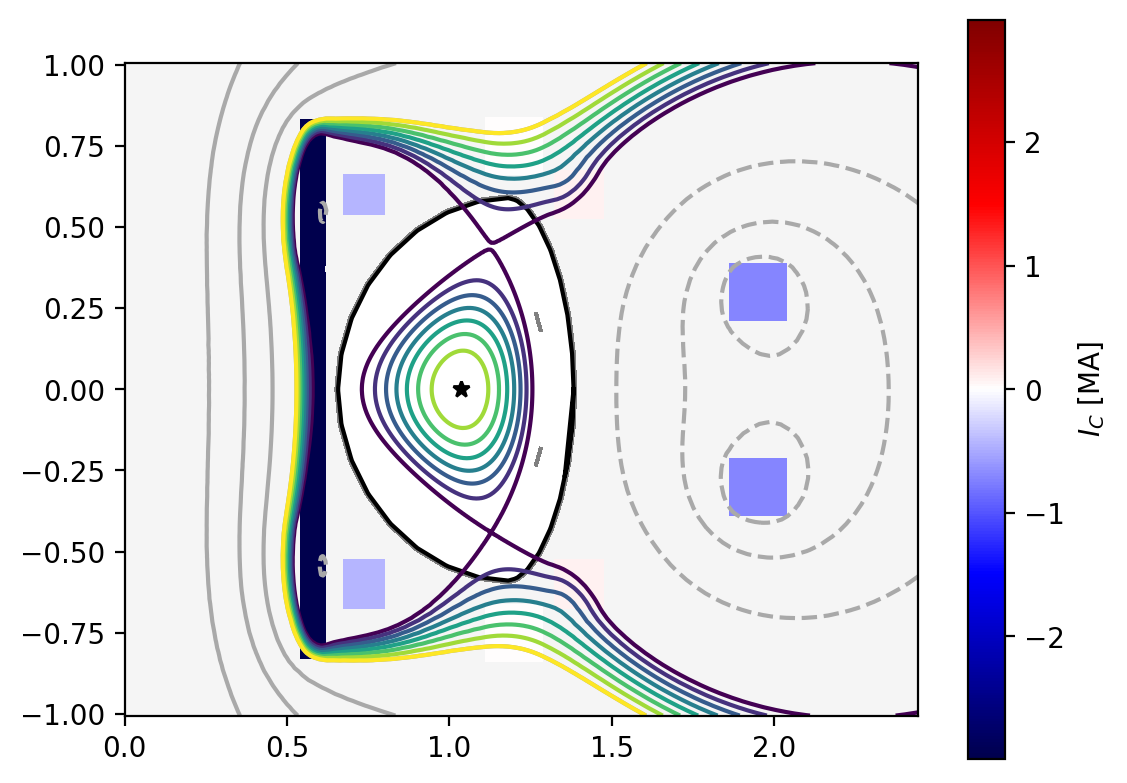

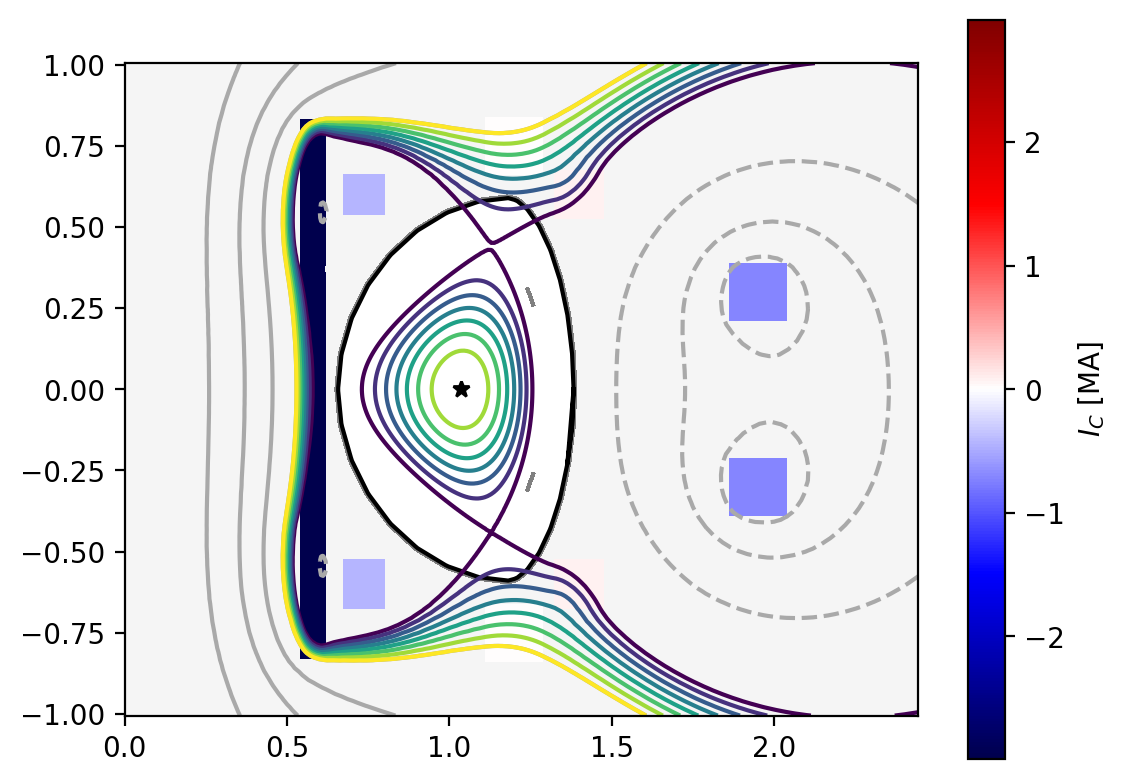

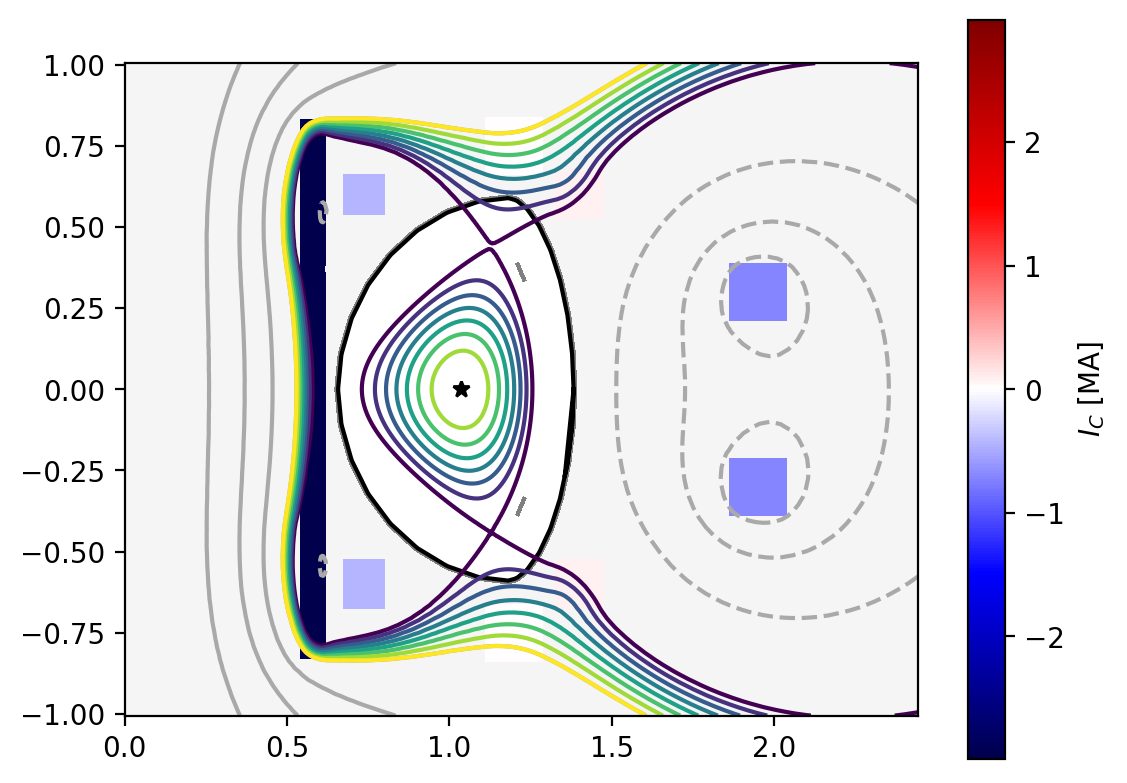

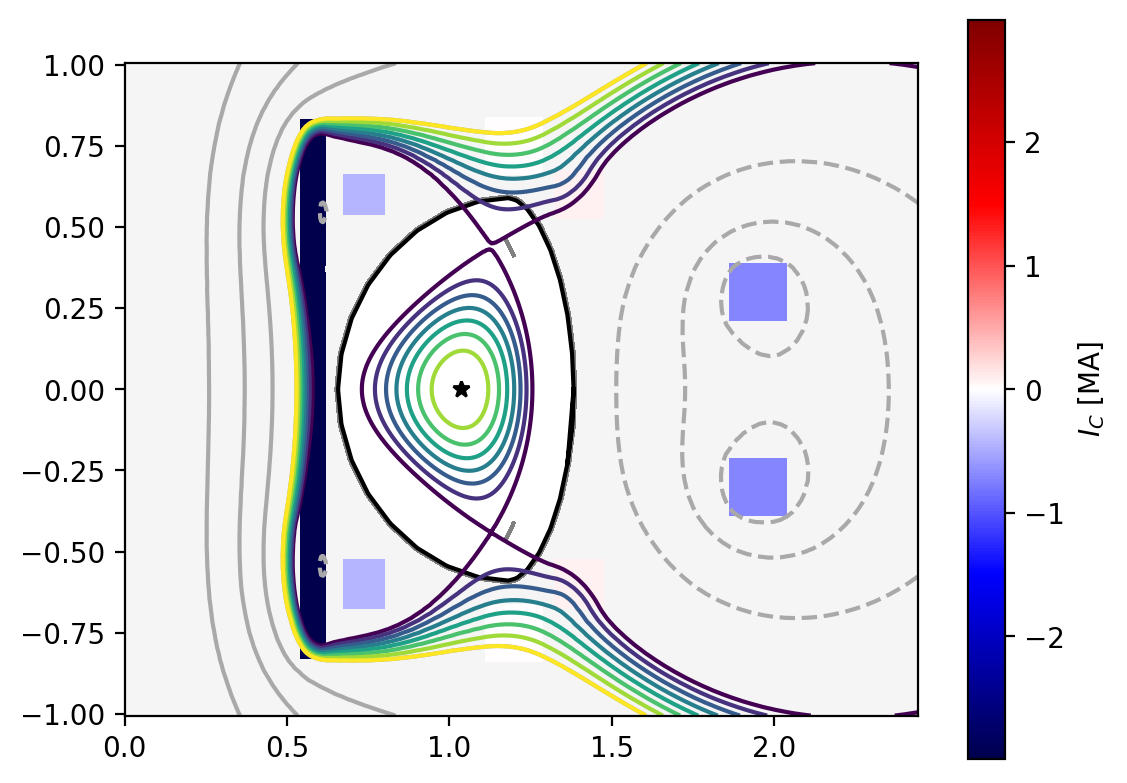

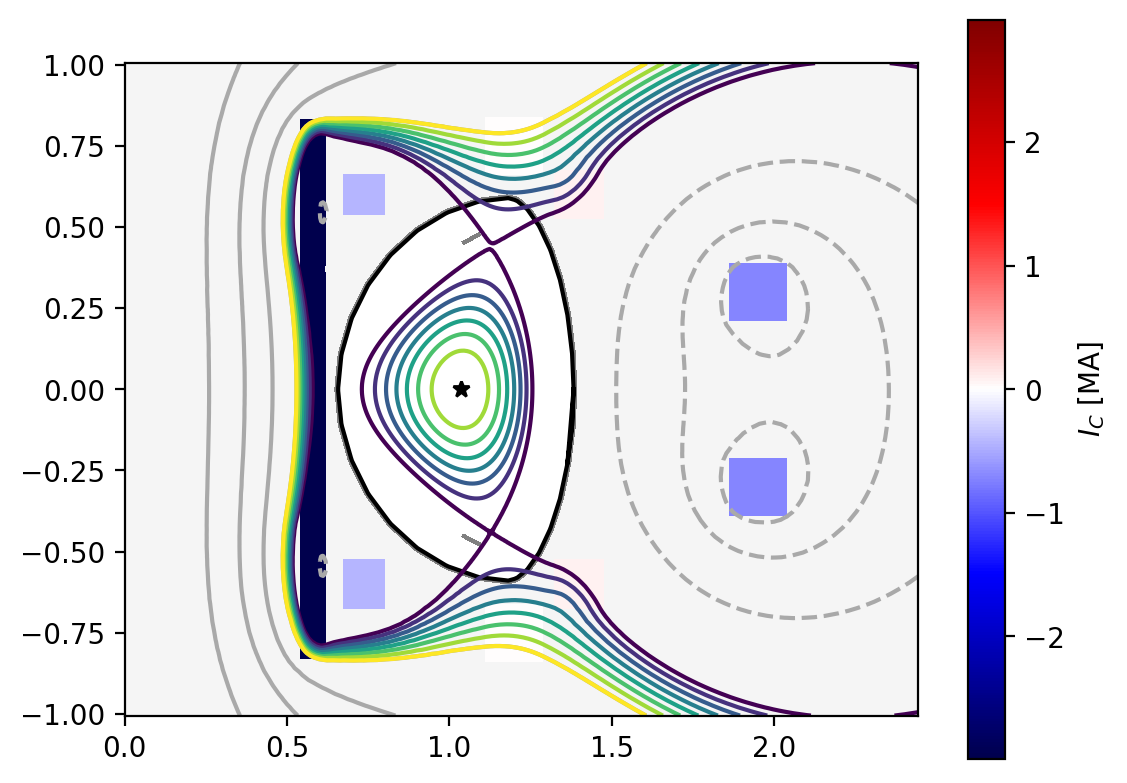

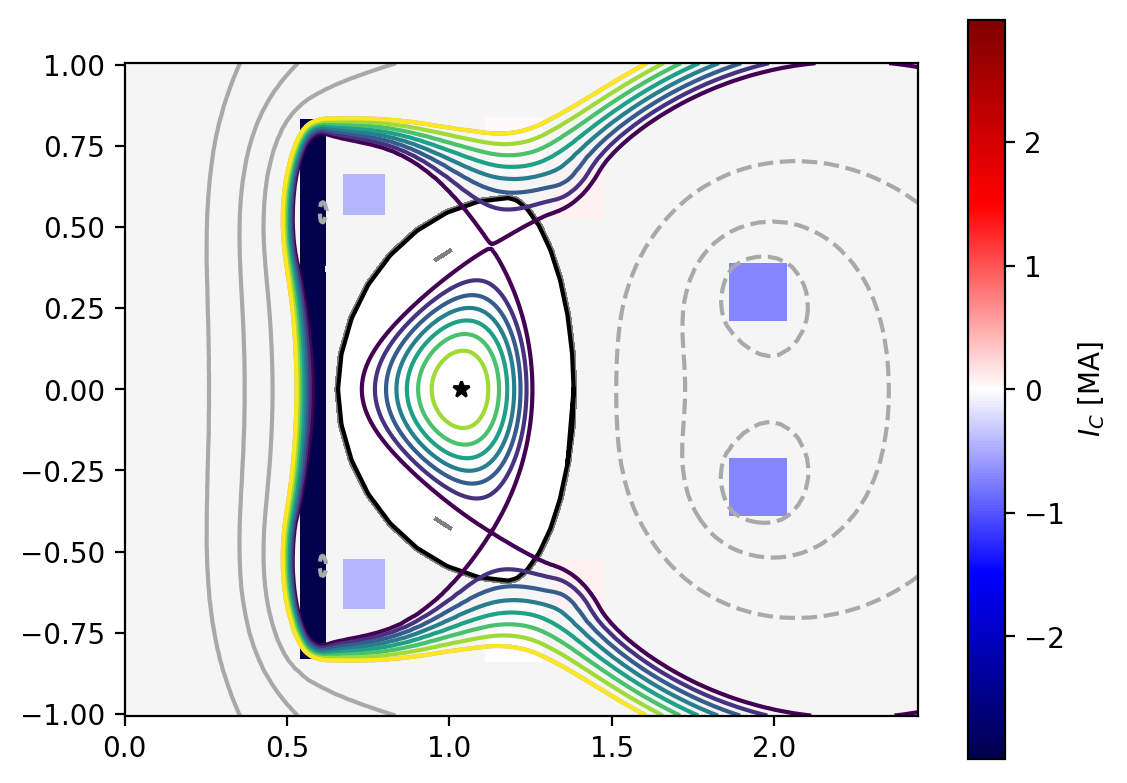

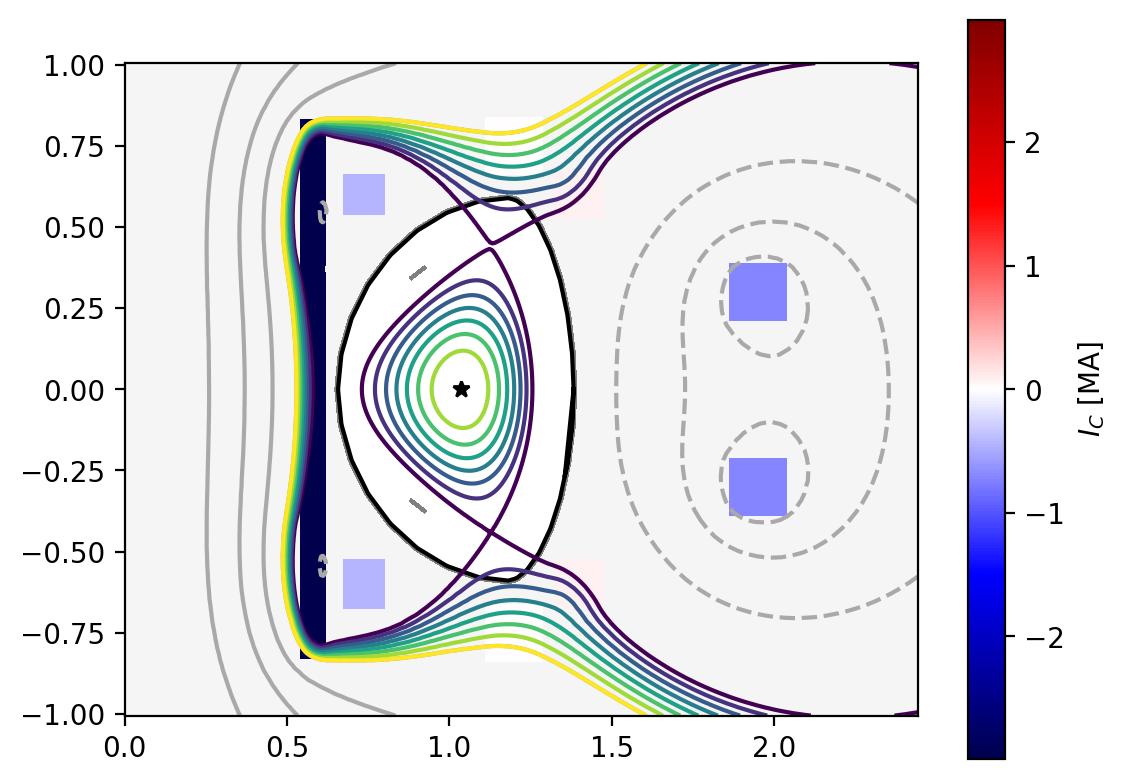

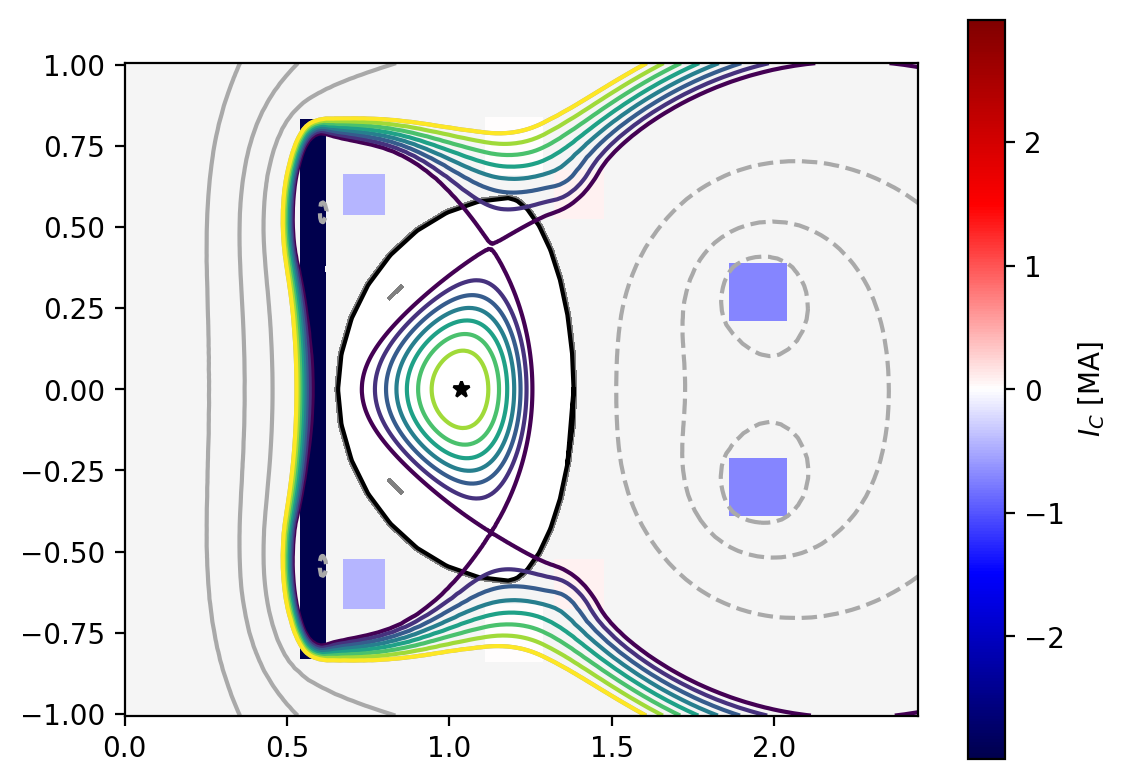

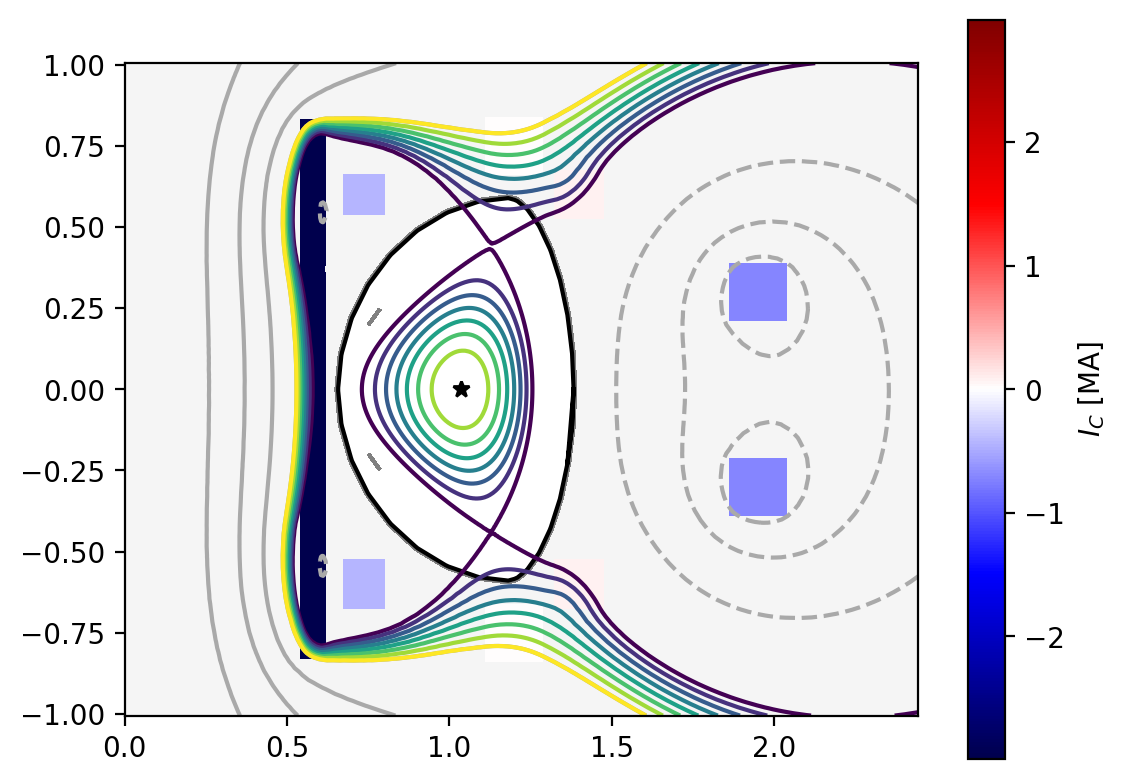

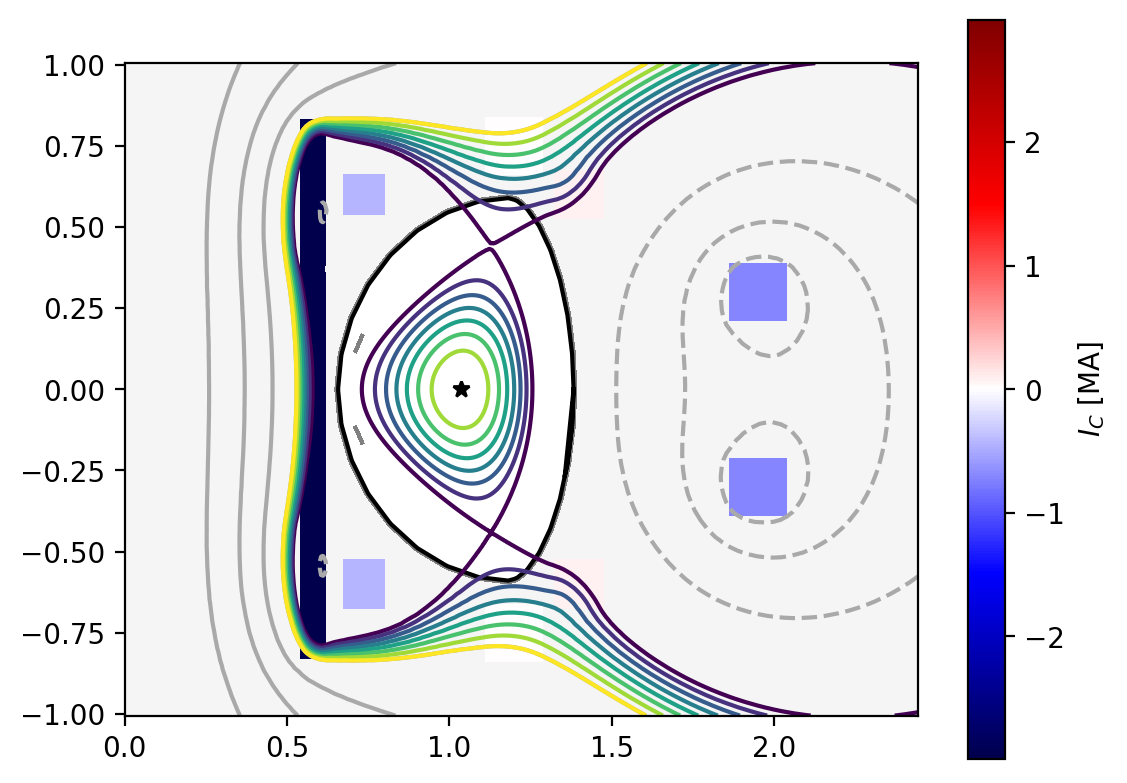

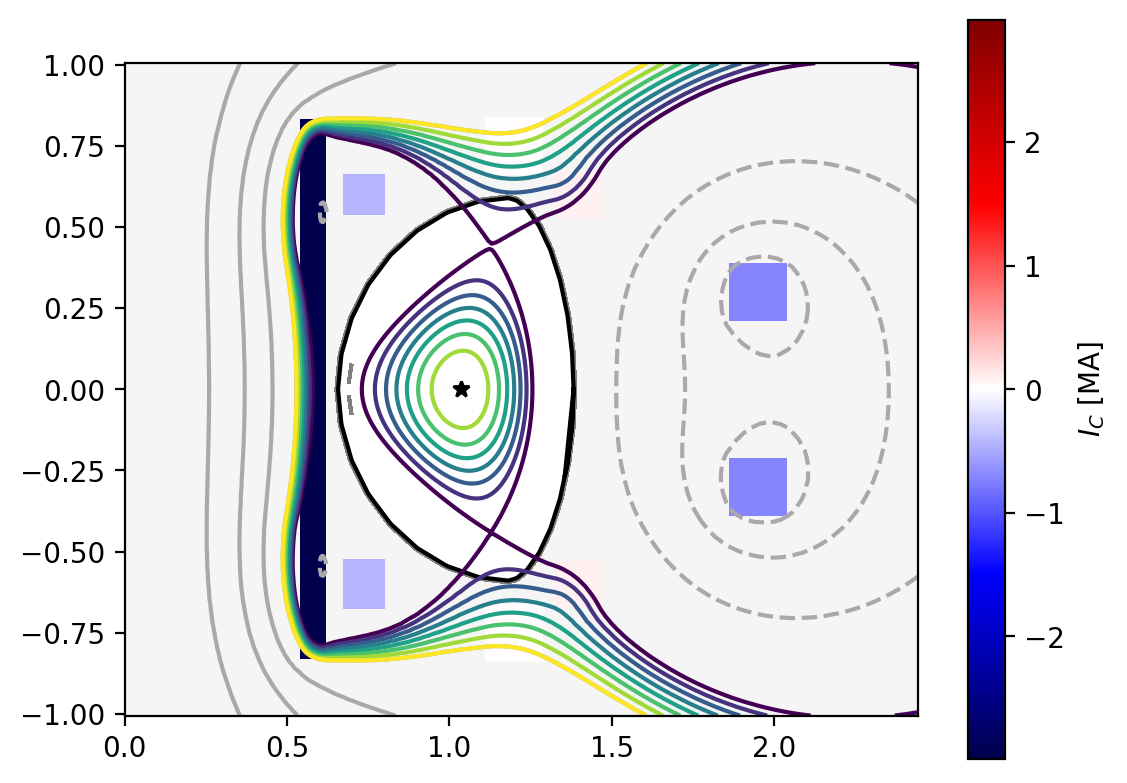

In [9]:
gammas = []

e = 1.7
d = -0.5

for i in range(13):
    # Create a G-S domain
    gs_mesh = gs_Domain()
    # Define region information for mesh
    gs_mesh.define_region('air',vac_dx,'boundary')                     # Define the bounding region
    gs_mesh.define_region('plasma',plasma_dx,'plasma')                 # Define the plasma region and resolution
    gs_mesh.define_region('vv',vv_dx,'conductor',eta=8.6E-7)

    # Define each of the PF coils
    for key, coil in coils.items():
        gs_mesh.define_region(key,coil_dx,'coil')

    gs_mesh.define_region('plate_upper',vv_dx,'conductor',eta=3.8E-8)
    gs_mesh.define_region('plate_lower',vv_dx,'conductor',eta=3.8E-8)

    gs_mesh.add_annulus(lim2, 'plasma', vv2, 'vv', parent_name = 'air')

    # Define each of the PF coils

    for key, coil in coils.items():
        gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')


    ps_b = np.copy(ps_points[i,:,:])
    ps_b[:,1] = -ps_b[:,1]
    gs_mesh.add_polygon(ps_points[i,:,:], 'plate_upper', parent_name = 'plasma')
    gs_mesh.add_polygon(ps_b, 'plate_lower', parent_name = 'plasma')

    #Create mesh
    mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
    coil_dict = gs_mesh.get_coils()
    cond_dict = gs_mesh.get_conductors()

    mygs = TokaMaker()
    mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
    mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
    mygs.setup(order = 2, F0 =1*3) ## F0 = B0 * R0

    coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
    targets = np.zeros(mygs.ncoils+1)
    coil_weights = 0.5*np.ones(mygs.ncoils+1)
    coil_weights[:3] = 5

    #Set target values for CS coils
    coil_reg_mat[0,0] = 1
    coil_reg_mat[1,1] = 1
    coil_reg_mat[1,0] = -1
    coil_reg_mat[2,2] = 1
    coil_reg_mat[2,1] = -1

    targets[0] = -3E6
    #Enforce up/down symmetry in PF coils
    coil_reg_mat[3,3] = 1
    coil_reg_mat[3,7] = -1
    coil_reg_mat[4,4] = 1
    coil_reg_mat[4,8] = -1
    coil_reg_mat[5,5] = 1
    coil_reg_mat[5,9] = -1
    coil_reg_mat[6,6] = 1
    coil_reg_mat[6,10] = -1
    mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

    #Set upper bound on coil currents
    coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
    coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
    #coil_bounds[-5:-1, 0] = 0
    #coil_bounds[-5:-1, 1] = 0
    mygs.set_coil_bounds(coil_bounds)

    # Define shape of P' anf FF' profiles
    n_sample = 40
    psi_sample = np.linspace(0.0,1.0,n_sample)
    # Set F*F' profile
    alpha = 2
    gamma = 1.25
    ffp_prof = {
        'type': 'linterp',
        'x': psi_sample,
        'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
    }
    ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
    # Set P' profile
    alpha = 2
    gamma = 1.25
    pp_prof = {
        'type': 'linterp',
        'x': psi_sample,
        'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
    }
    pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

    mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

    # set global targets
    Ip_target = 0.75E6
    mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

    # set boundary/saddle point targets
    r, z, zeff = boundaryShape(kapu = e, kapl = e, delu = d, dell = d, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/1, zoffset = 0, upnull = True, lonull = True, npts = 8)
    boundary = np.column_stack((r,z))
    boundary = np.nan_to_num(boundary)

    x_points = np.zeros((2,2))
    x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
    x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
    x_weights = 50*np.ones(2)
    mygs.set_saddles(x_points, x_weights)
    
    isoflux_weights = 50*np.ones(len(boundary))
    mygs.set_isoflux(boundary, isoflux_weights)
    #find equilibrium
    mygs.init_psi(0.68,0,0.2, 1.8,0.3)
    mygs.settings.maxits = 100
    mygs.update_settings()
    mygs.solve()

    #plot equilibrium
    fig, ax = plt.subplots(1,1)
    mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
    mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
        
    
    #save as eqdsk
    eig_vals, eig_vecs = mygs.eig_td(-1.E5,10, include_bounds = True)
    gammas.append(eig_vals[0,0])

    mygs.reset()



In [10]:
print(gammas)

[-1281.2415374148259, -803.6982384776638, -432.65113013770315, -278.8762540248572, -280.87466424425656, -427.09341782423144, -429.42474100820255, -319.7784194755368, -396.9947035469522, -616.9250604784756, -971.8397471361241, -1288.7431170102936, -1439.0829873736802]


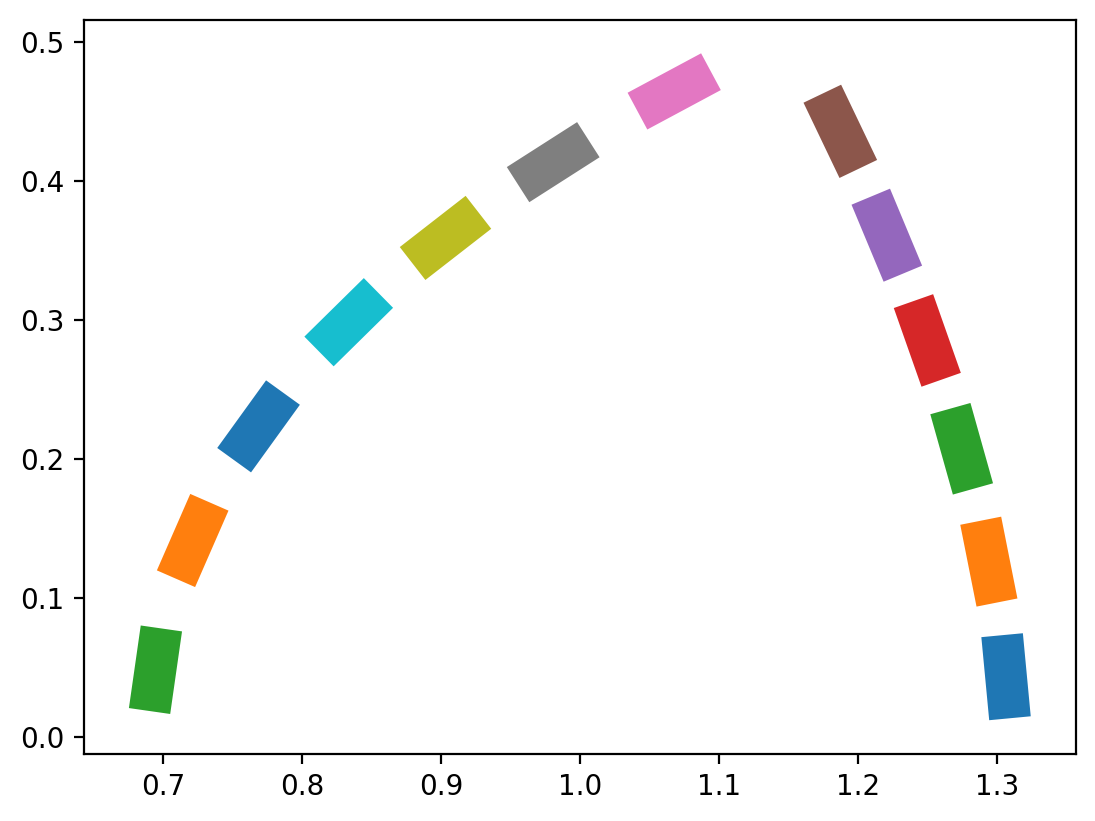

In [11]:
derivs = []
for i, point in enumerate(plate_arc):
    if i==0:
        last = plate_arc[-1,:]
        next = plate_arc[i+1,:]
    elif i == np.size(plate_arc[:,0])-1:
        last = plate_arc[i-1,:]
        next = plate_arc[0,:]
    else: 
        next = plate_arc[i+1,:]
        last = plate_arc[i-1,:]
    
    derivs.append((next-last)/np.linalg.norm(next-last))

derivs = np.array(derivs)
orth = np.transpose([derivs[:,1], -derivs[:,0]])
length = .06
width = .03
ps_points = []
for i in inds:
    center = plate_arc[i,:]
    p1 = center + length/2*derivs[i,:] + width/2*orth[i,:]
    p2 = center + length/2*derivs[i,:] - width/2*orth[i,:]
    p3 = center - length/2*derivs[i,:] - width/2*orth[i,:]
    p4 = center - length/2*derivs[i,:] + width/2*orth[i,:]

    ps_points.append([p1, p2, p3, p4])

ps_points = np.array(ps_points)
for i in range(13):
    plt.fill(ps_points[i,:,0], ps_points[i,:,1])

plt.gca().set_aspect(aspect = 1)

Text(0.67, 0.47, '(a)')

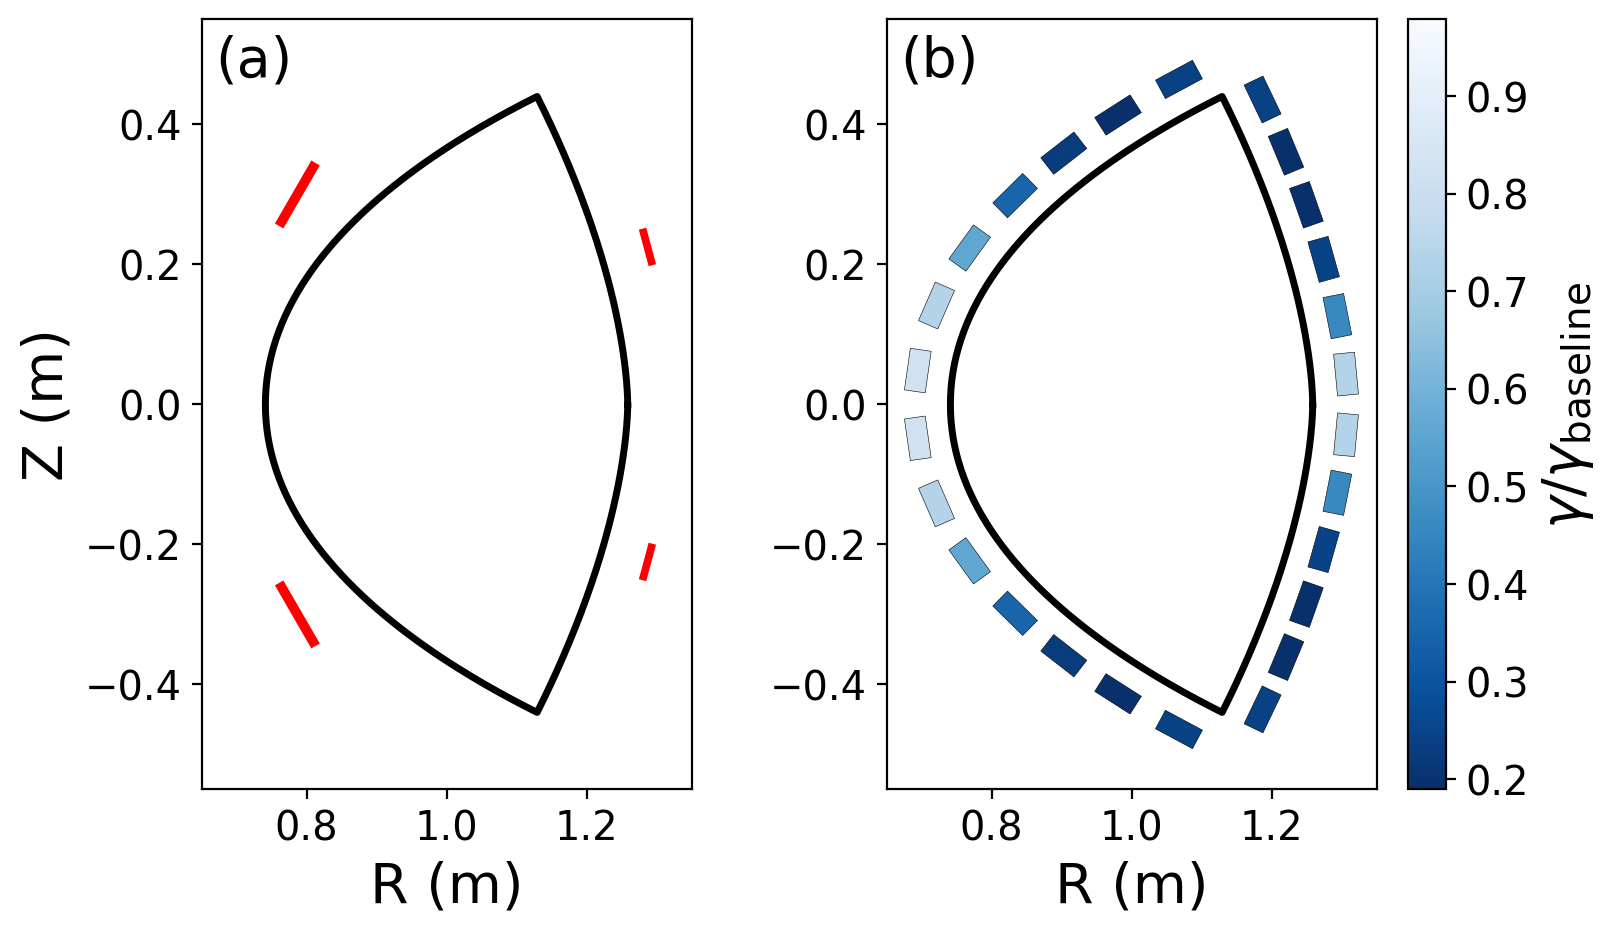

In [24]:
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'
fig, ax = plt.subplots(1,2, figsize = (8.8,5))
#plt.fill(vv2[:,0], vv2[:,1], color = 'k')
#plt.fill(lim2[:,0], lim2[:,1], color = 'w')

ax[1].set_aspect(aspect = 1)

norm = plt.Normalize(np.min(-np.array(gammas))/1470.8062489965814 , np.max(-np.array(gammas))/1470.8062489965814 )
import matplotlib as mpl
cmap = mpl.cm.Blues_r(np.linspace(0,1,1000))
cmap = mpl.colors.ListedColormap(cmap[:,:-1])


c = cmap(norm(-np.array(gammas)/1750.89401618 ))

for i in range(13):
    ax[1].fill(ps_points[i,:,0], ps_points[i,:,1], facecolor = c[i], edgecolor = 'k', lw = .2)
    ax[1].fill(ps_points[i,:,0], -ps_points[i,:,1], facecolor = c[i], edgecolor = 'k', lw = .2)
    

sm = plt.cm.ScalarMappable(cmap=cmap, norm = norm)
cb = plt.colorbar(sm, ax = ax[1])
cb.set_label(label=r'$\gamma / \gamma_{\mathrm{baseline}}$', size = 20)

ax[1].set_xlabel('R (m)', size = 20)
ax[0].set_ylabel('Z (m)', size = 20)
#cb.ax.set_yticks([0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
#cb.ax.set_yticklabels(['0.20', '0.25', '0.30', '0.35', '0.40', '0.45', r'$\geq$ 0.50' ])



e = 1.7
d = -0.5
r, z, zeff = boundaryShape(kapu = e, kapl = e, delu = d, dell = d, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/1, zoffset = 0, upnull = True, lonull = True)
boundary = np.column_stack((r,z))

ax[1].plot(boundary[:,0], boundary[:,1], color = 'k', linewidth = 2.5)

ax[1].set_xlim([0.65,1.35])
ax[1].set_ylim([-0.55, 0.55])

ax[0].plot(boundary[:,0], boundary[:,1], color = 'k', linewidth = 2.5)
ax[0].set_aspect(aspect = 1)
ax[0].set_xlabel('R (m)', size = 20)
ax[0].fill((np.array(nsf_geom['in_upper_plate'])/1000)[:,0], (np.array(nsf_geom['in_upper_plate'])/1000)[:,1], color = 'r')
ax[0].fill((np.array(nsf_geom['in_lower_plate'])/1000)[:,0], (np.array(nsf_geom['in_lower_plate'])/1000)[:,1], color = 'r')
ax[0].fill((np.array(nsf_geom['out_upper_plate'])/1000)[:,0], (np.array(nsf_geom['out_upper_plate'])/1000)[:,1], color = 'r')
ax[0].fill((np.array(nsf_geom['out_lower_plate'])/1000)[:,0], (np.array(nsf_geom['out_lower_plate'])/1000)[:,1], color = 'r')

ax[0].set_xlim([0.65,1.35])
ax[0].set_ylim([-0.55, 0.55])

ax[1].text(0.67, 0.47, '(b)', fontsize = 20)
ax[0].text(0.67, 0.47, '(a)', fontsize = 20)